# Prostate-specific antigen (PSA) analysis

# Document information

<table align="left">
    <tr>
        <th class="text-align:left">Title</th>
        <td class="text-align:left">Protein-specific antigen (PSA) analysis</td>
    </tr>
    <tr>
        <th class="text-align:left">Last modified</th>
        <td class="text-align:left">2019-09-24</td>
    </tr>
    <tr>
        <th class="text-align:left">Author</th>
        <td class="text-align:left">Gilles Pilon <gillespilon13@gmail.com></td>
    </tr>
    <tr>
        <th class="text-align:left">Status</th>
        <td class="text-align:left">Active</td>
    </tr>
    <tr>
        <th class="text-align:left">Type</th>
        <td class="text-align:left">Jupyter notebook</td>
    </tr>
    <tr>
        <th class="text-align:left">Created</th>
        <td class="text-align:left">2017-08-02</td>
    </tr>
    <tr>
        <th class="text-align:left">File name</th>
        <td class="text-align:left">psa_analysis.ipynb</td>
    </tr>
    <tr>
        <th class="text-align:left">Other files required</th>
        <td class="text-align:left">psa_proudlove.csv<br />psa_perry.csv<br />psa_all.csv</td>
    </tr>
</table>

## In brevi

Prostate-specific antigen (PSA) is produced for the ejaculate, where it liquifies the semen in the seminal coagulum and allows sperm to swim freely (Balk et.al. 2003). PSA is present in small quantities in the serum of men with healthy prostates, but is often elevated in the presence of prostate cancer or other prostate disorders (Catalona et.al. 1994).

I was diagnosed with prostate cancer on 2013-03-08. I had a radical prostatectomy on 2013-06-11 and 30 radiation treatments from 2013-09-13 to 2013-10-18.

From an initial PSA test immediately after the last radiation treatment and every six months since, I have recorded the date, results, and consulting physician. These results are analysed in this Jupyter notebook.

This Jupyter Notebook creates three scatter plots:

1. PSA v. Date, using the full range of the data to set the y axis limits.
2. PSA v. Date, using the *trigger point* of 3.0 to set the y axis limits. This upper limit is the point at which the doctors said I would need further treatment if my PSA results were to reach this value.
3. PSA v. Date, using the full range of the data to set the y axis limits, and a linear regression line fitted to the data.

## Methodology

Three plots are drawn with pandas.DataFrame.plot. Ordinary least squares (OLS) regression is estimated with statsmodels.

## Data

Download the three data files:

- [PSA results from Dr. Proudlove](https://drive.google.com/open?id=0BzrdQfHR2I5DdHNFMWtSQ3JSclE)
- [PSA results from Dr. Perry](https://drive.google.com/open?id=0BzrdQfHR2I5DdF9pRUM1c1FZZmM)
- [PSA results from Dr. Proudlove and Dr. Perry](https://drive.google.com/open?id=1P-m2GIVUq9o68cvTXa16-cpfb3xMp7fw)

In [1]:
from datetime import datetime
start_time = datetime.now()

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.axes as axes
import statsmodels.formula.api as smf
import statsmodels.regression.linear_model
from typing import Tuple


# https://matplotlib.org/tutorials/colors/colormaps.html
c = cm.Paired.colors # c[0] c[1] ... c[11]


%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [3]:
def despine(ax: axes.Axes) -> None:
    '''
    Remove the top and right spines of a graph.

    Used to enforce standard and *correct* style. There is only one x, and one
    y axis, left and bottom, therefore there should only be these axes.
    '''
    for spine in 'right', 'top':
        ax.spines[spine].set_visible(False)

In [4]:
def psa_reg(df: pd.DataFrame) ->\
        Tuple[pd.DataFrame,
              statsmodels.regression.linear_model.RegressionResultsWrapper,
              str]:
    df['Julian'] = df.index.to_julian_date()
    results = smf.ols(formula='PSA ~ Julian', data=df).fit()
    parameters = results.params
    julian_predicted = (3.0 - parameters[0])/parameters[1]
    gregorian_predicted = pd.to_datetime(julian_predicted, unit='D',
                                         origin='julian')\
                            .strftime('%Y-%m-%d')
    df['Predicted'] = results.predict(df['Julian'])
    df = df.drop(columns='Julian')
    return df, results, gregorian_predicted

/usr/lib/python3.7/site-packages/scipy/stats/stats.py:1450: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  "anyway, n=%i" % int(n))


My PSA will reach 3.0 on 2141-04-14.

                            OLS Regression Results                            
Dep. Variable:                    PSA   R-squared:                       0.818
Model:                            OLS   Adj. R-squared:                  0.800
Method:                 Least Squares   F-statistic:                     44.95
Date:                Tue, 22 Oct 2019   Prob (F-statistic):           5.33e-05
Time:                        11:43:26   Log-Likelihood:                 30.010
No. Observations:                  12   AIC:                            -56.02
Df Residuals:                      10   BIC:                            -55.05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -1

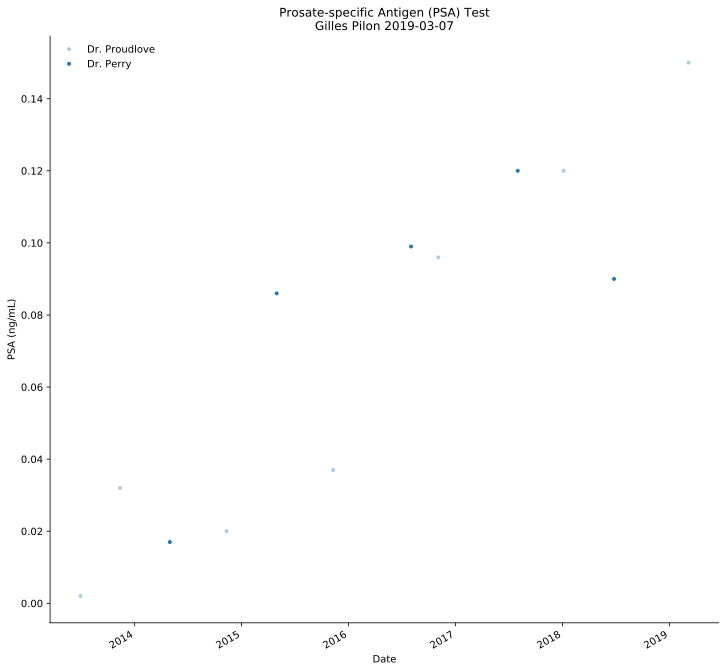

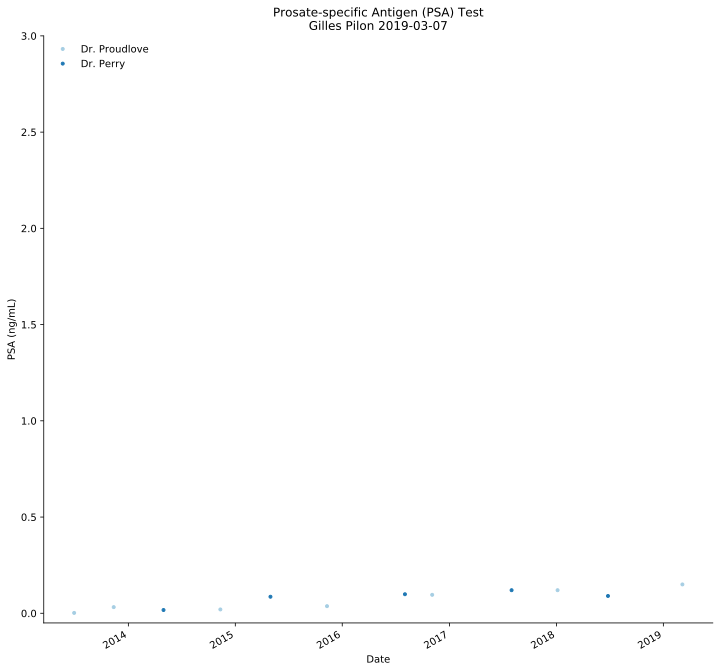

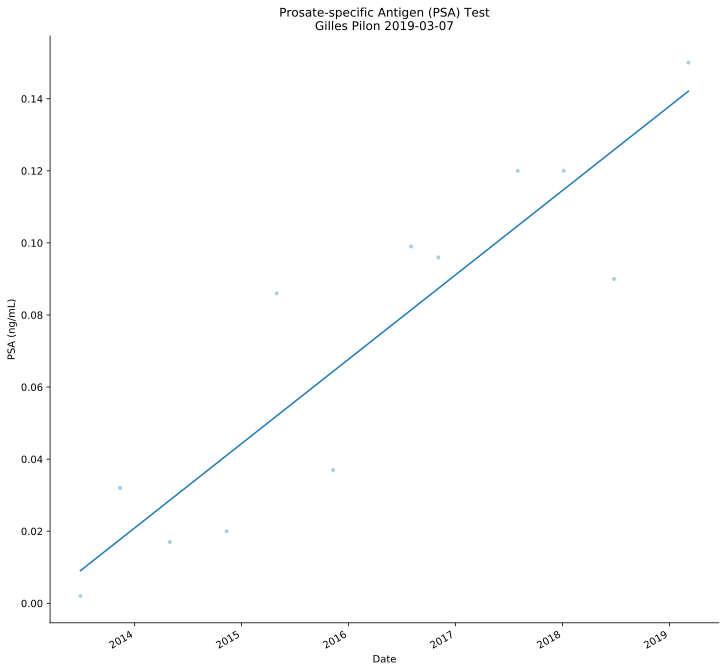

In [5]:
if __name__ == '__main__':
    psa_proudlove = pd.read_csv('psa_proudlove.csv',
                                parse_dates=True,
                                index_col='Date')
    psa_perry = pd.read_csv('psa_perry.csv',
                            parse_dates=True,
                            index_col='Date')
    psa_all = pd.read_csv('psa_all.csv',
                          parse_dates=True,
                          index_col='Date')
    title = 'Prosate-specific Antigen (PSA) Test'
    max_date = max(psa_proudlove.index.max(),
                   psa_perry.index.max()).date().isoformat()
    subtitle = f'Gilles Pilon {max_date}'
    yaxislabel = 'PSA (ng/mL)'
    xaxislabel = 'Date'
    psa_all, results, gregorian_predicted = psa_reg(psa_all)
    todo = [
        (psa_proudlove, psa_perry, 'PSA', 'PSA', None, '.', '.',
            'gilles_psa'),
        (psa_proudlove, psa_perry, 'PSA', 'PSA', (-0.05, 3), '.', '.',
            'gilles_psa_max'),
        (psa_all, psa_all, 'PSA', 'Predicted', None, '.', '-',
            'gilles_psa_regression')
           ]
    for df1, df2, y1, y2, ylim, g1, g2, filename in todo:
        fig, ax = plt.subplots(figsize=(12, 12))
        df1.plot(y=y1,
                 color=c[0],
                 style=g1,
                 label='Dr. Proudlove',
                 ax=ax)
        df2.plot(y=y2,
                 color=c[1],
                 style=g2,
                 label='Dr. Perry',
                 ax=ax)
        despine(ax)
        ax.set_title(f'{title}\n{subtitle}')
        ax.set_ylabel(yaxislabel)
        ax.set_xlabel(xaxislabel)
        ax.autoscale(tight=False)
        if ylim is not None:
            ax.set_ylim(*ylim)
        if df1 is not psa_all:
            ax.legend(loc='upper left', frameon=False)
        else:
            ax.get_legend().remove()
        ax.figure.savefig(f'{filename}.svg', format='svg')
        ax.figure.savefig(f'{filename}.png', format='png')
        ax.figure.savefig(f'{filename}.pdf', format='pdf')
    print(f'My PSA will reach 3.0 on {gregorian_predicted}.'
          f'\n\n{results.summary()}')

In [6]:
end_time = datetime.now()
(end_time - start_time).total_seconds()

2.216013

## References

Balk, S.P. Y.J. Ko, and G.J. Bubley. "Biology of prosate-specific antigen." *Journal of Clinical Oncology* 21 (January 2003), no. 2: 383-91. [PMID 12525533 (https://www.ncbi.nlm.nih.gov/pubmed/12525533)](https://www.ncbi.nlm.nih.gov/pubmed/12525533). [doi:10.1200/JCO.2003.02.083 (https://doi.org/10.1200 2FJCO.2003.02.083)](https://doi.org/10.1200/JCO.2003.02.083).

Catalona, W.J., J.P. Richie, F.R. Ahmann, M.A. Hudson, P.T. Scardino, R.C. Flanigan, J.B. deKernion, T.L. Ratliff, L.R. Kavoussi, and B.L. Dalkin. "Comparison of digital rectal examination and serum prostate specific antigen in the early detection of prostate cancer: results of a multicenter clinical trial of 6,630 mean." *The Journal of Urology* 151 (May 1994), no. 5: 1283-90. [PMID 7512659 (https://www.ncbi.nlm.nih.gov/pubmed/7512659)](https://www.ncbi.nlm.nih.gov/pubmed/7512659).
